In [1]:
import math
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter

from skimage.io import imread
from skimage.data import shepp_logan_phantom
from skimage.transform import iradon, iradon_sart, radon, rescale

import pickle
import os
import multiprocessing as mp
import glob

import time

### Multi-threaded reading of view measurements from csv

In [79]:
count_errors = itertools.count() #I am not perfectly sure if this is atomic.
#Atomic stuff seems to be a surprising downside of Python
# - at least I couldn't find trivial packages for this purpose.

def set_strip(inp):
    (csv_path, idx, shared_list, do_exp)=inp
    try:
        arr=np.genfromtxt(csv_path,delimiter=',')
        if do_exp:
            arr=np.exp(arr)
            arr=np.clip(arr,0,255)
            arr=np.uint8(arr)
        else:
            arr=(arr-np.min(arr))/(np.max(arr)-np.min(arr))*255
        #im=Image.fromarray(arr)
        shared_list[idx]=arr#im
    except: #Some csv-s are empty, DON'T KNOW WHY
        value = next(count_errors)
        print(f"ERROR number {value} in file {csv_path}")

def get_strips(dose, do_exp=False, max_cnt=None, parallel_jobs=mp.cpu_count()):
    views_location=f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/out"
    cnt=0
    csv_paths=sorted(glob.glob(f"{views_location}/*.csv"),key=lambda x:int(x[59:-4]))
    if not max_cnt:
        max_cnt=len(csv_paths)

    start = time.time()
    print(f"Reading of {dose} dose input started")
    print(f"It will take approximately {3.0*max_cnt/48000} minutes on Hulk5 or {5.0*max_cnt/48000} on Gpu2.")

    with mp.Manager() as manager:    
        strips = manager.list([None]*max_cnt)
        pool = mp.Pool(parallel_jobs)
        pool.map(set_strip, zip(csv_paths[:max_cnt],range(max_cnt),[strips]*max_cnt,[do_exp]*max_cnt))
        strips=np.array([x for x in list(strips) if x is not None])
        pool.close()
    end = time.time()
    print(f"Reading of {dose} mAs dose input has finished")
    print(f"{len(strips)} views were read")
    print(f"It took {(end - start)/60} minutes")
    
    return strips

In [62]:
doses=["020","080","280"]
used_doses=doses # OR ["280"]
strips=dict()
for dose in used_doses:
    strips[dose]=get_strips(dose, max_cnt=15000)

Reading of 020 dose input started
It will take approximately 0.9375 minutes on Hulk5 or 1.5625 on Gpu2.
Reading of 020 dose input has finished
15000 views were read
It took 1.2007798989613852 minutes
Reading of 080 dose input started
It will take approximately 0.9375 minutes on Hulk5 or 1.5625 on Gpu2.
Reading of 080 dose input has finished
15000 views were read
It took 1.040107496579488 minutes
Reading of 280 dose input started
It will take approximately 0.9375 minutes on Hulk5 or 1.5625 on Gpu2.
Reading of 280 dose input has finished
15000 views were read
It took 1.0017849326133728 minutes


### Defining sinogram creators

In [63]:
ANGLES=720*2*2 #Number of views to use for a sinogram
HALF_ANGLES=ANGLES//2
PROJECTIONS=896
HALF_PROJECTIONS=PROJECTIONS//2
START_PERIOD=4 #From where to take the views for the sinogram. If x, then view number x*ANGLES is the first view to use.
SMALL_R=518
BIG_R=910
FULL_CIRCLE=2*math.pi
SEMI_CIRCLE=FULL_CIRCLE/2
PERPENDICULAR_ANGLE=math.pi/2

In [64]:
MAX_DISPLACEMENT=math.sqrt(SMALL_R**2-(BIG_R/2)**2)
HALF_VIEW_ANGLE=math.asin(MAX_DISPLACEMENT/SMALL_R)
VIEW_ANGLE=2*HALF_VIEW_ANGLE

In [65]:
def plot_sinogram(sinogram, method, angle_range=180.0):
    plt.figure()
    plt.title(method)
    plt.xlabel('angle (pixel)')
    plt.ylabel('projection (pixel)')
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)
    plt.show()

In [9]:
def create_sinogram_stupid_360(strips, shift=0):
    sinogram = Image.new('L', (ANGLES,PROJECTIONS))
    for idx in range(START_PERIOD*ANGLES+shift,(START_PERIOD+1)*ANGLES+shift):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[idx]),axis=0),axis=1))
        i=idx-(START_PERIOD*ANGLES+shift)
        sinogram.paste(strip, (i, 0))
    plot_sinogram(sinogram,"sinogram_stupid_360",360)
    return sinogram

In [10]:
def create_sinogram_stupid_180(strips):
    sinogram = Image.new('L', (HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=(idx-START_PERIOD*ANGLES)
        for j in range(PROJECTIONS):
            if(i<HALF_ANGLES):
                pixels[i,j]+=int(strip[j]/2)
            else:
                pixels[i-HALF_ANGLES,PROJECTIONS-j-1]+=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_stupid_180",180)
    return sinogram

In [11]:
def create_sinogram_stupid_full(strips):
    num=len(strips)
    sinogram = Image.new('L', (PROJECTIONS, num))
    for i in range(num):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[i]),axis=0),axis=1))
        sinogram.paste(strip, (i, 0))
    plot_sinogram(sinogram,"sinogram_stupid_full",num)
    return sinogram

In [12]:
def create_sinogram_intuitive_360(strips):
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j)%ANGLES,j]=int(strip[j])
    plot_sinogram(sinogram,"sinogram_intuitive_360",360)
    return sinogram

In [13]:
def create_sinogram_intuitive_180(strips):
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j)%HALF_ANGLES,j]=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_intuitive_180",180)
    return sinogram

In [14]:
def create_sinogram_intuitive_param_180(strips,slope):
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j*slope)%HALF_ANGLES,j]=int(strip[j]/2)
    plot_sinogram(sinogram,"sinogram_intuitive_180",180)
    return sinogram

In [66]:
def my_round(v,maxi):
    return min(maxi-1,round(v))

In [7]:
def my_round_vec(v,maxi):
    return np.minimum(np.round(v),maxi-1).astype(int)

In [16]:
def create_sinogram_trigonometry_360(strips):
    
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.min(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS+j])
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS-j])
    
    
    plot_sinogram(sinogram, "sinogram_trigonometry_360",360)
    return sinogram

In [17]:
def create_sinogram_trigonometry_reverse_360(strips):
    
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.min(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS+j])
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS-j])
    
    
    plot_sinogram(sinogram, "sinogram_trigonometry_360",360)
    return sinogram

In [18]:
def create_sinogram_trigonometry_normal(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(-HALF_VIEW_ANGLE,HALF_VIEW_ANGLE,PROJECTIONS,endpoint=False)  #[::-1]
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(PROJECTIONS):
            normal_angle=(central_angles[i]+displacement_angles[j]+PERPENDICULAR_ANGLE)%FULL_CIRCLE
            projection_dist=displacements[j]
            if normal_angle > SEMI_CIRCLE+PERPENDICULAR_ANGLE:
                normal_angle-=SEMI_CIRCLE
                projection_dist*=(-1)
            projection_pixel=my_round(PROJECTIONS*((projection_dist-MAX_DISPLACEMENT)/(2*MAX_DISPLACEMENT)),PROJECTIONS)
            angle_pixel=my_round(HALF_ANGLES*(normal_angle/SEMI_CIRCLE),HALF_ANGLES)
            pixels[angle_pixel,projection_pixel]+=int(strip[j]/2)
            
    plot_sinogram(sinogram, "sinogram_trigonometry_normal",180)
    return sinogram

In [19]:
def create_sinogram_trigonometry_180(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(HALF_ANGLES*angle_rad/FULL_CIRCLE,HALF_ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]+=int(strip[HALF_PROJECTIONS+j]/2)
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(HALF_ANGLES*angle_rad/FULL_CIRCLE,HALF_ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]+=int(strip[HALF_PROJECTIONS-j]/2)
    plot_sinogram(sinogram, "sinogram_trigonometry_180",180)
    return sinogram

In [67]:
def create_sinogram_trigonometry_reverse_old(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS),color=0)
    pixels=sinogram.load()
    
    for angle_pixel in range(HALF_ANGLES):
        theta=SEMI_CIRCLE*angle_pixel/HALF_ANGLES
        for proj_pixel in range(PROJECTIONS):
            s=-MAX_DISPLACEMENT+(proj_pixel/PROJECTIONS)*2*MAX_DISPLACEMENT
            beta=math.asin(s/SMALL_R)
            alpha=theta-beta
            
            P=my_round(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE),PROJECTIONS)
            V=my_round(HALF_ANGLES*(alpha/SEMI_CIRCLE),HALF_ANGLES)
            val=np.mean(strips[START_PERIOD*ANGLES+V],axis=0)[P]
            
            pixels[angle_pixel, my_round(PROJECTIONS-proj_pixel,PROJECTIONS)]=int(val)
        
            
    plot_sinogram(sinogram, "sinogram_trigonometry_reverse",180)
    return sinogram

In [21]:
def create_sinogram_trigonometry_reverse(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS),color=0)
    pixels=sinogram.load()
    
    for angle_pixel in range(HALF_ANGLES):
        theta=SEMI_CIRCLE*angle_pixel/HALF_ANGLES
        for proj_pixel in range(PROJECTIONS):
            s=-MAX_DISPLACEMENT+(proj_pixel/PROJECTIONS)*2*MAX_DISPLACEMENT
            beta=math.asin(s/SMALL_R)
            alpha=theta-beta
            
            P=my_round(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE),PROJECTIONS)
            V=my_round(HALF_ANGLES*(alpha/SEMI_CIRCLE),HALF_ANGLES)
            val=np.mean(np.array(strips[START_PERIOD*ANGLES+V]),axis=0)[P]/2
            
            P_opposite=my_round(PROJECTIONS*((HALF_VIEW_ANGLE-beta)/VIEW_ANGLE),PROJECTIONS)
            V_opposite=my_round(HALF_ANGLES*((alpha+SEMI_CIRCLE)/SEMI_CIRCLE),ANGLES)
            val_opposite=np.mean(np.array(strips[START_PERIOD*ANGLES+V_opposite]),axis=0)[P_opposite]/2
            
            pixels[angle_pixel, my_round(PROJECTIONS-proj_pixel,PROJECTIONS)]=int(val+val_opposite)
        
            
    plot_sinogram(sinogram, "sinogram_trigonometry_reverse",180)
    return sinogram

In [39]:
def set_pixel(inp):
    (strips, pixels, angle_pixel, proj_pixel)=inp
    
    theta=SEMI_CIRCLE*angle_pixel/HALF_ANGLES
    s=-MAX_DISPLACEMENT+(proj_pixel/PROJECTIONS)*2*MAX_DISPLACEMENT
    
    beta=math.asin(s/SMALL_R)
    alpha=theta-beta

    P=my_round(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE),PROJECTIONS)
    V=my_round(HALF_ANGLES*(alpha/SEMI_CIRCLE),HALF_ANGLES)
    val=np.mean(np.array(strips[START_PERIOD*ANGLES+V]),axis=0)[P]/2

    P_opposite=my_round(PROJECTIONS*((HALF_VIEW_ANGLE-beta)/VIEW_ANGLE),PROJECTIONS)
    V_opposite=my_round(HALF_ANGLES*((alpha+SEMI_CIRCLE)/SEMI_CIRCLE),ANGLES)
    val_opposite=np.mean(np.array(strips[START_PERIOD*ANGLES+V_opposite]),axis=0)[P_opposite]/2
    
    pixels[angle_pixel, my_round(PROJECTIONS-proj_pixel,PROJECTIONS)]=int(val+val_opposite)
    

def create_sinogram_parallel(strips, parallel_jobs=mp.cpu_count()): #VEEEEEERY SLOW, I DON'T HAVE A CLUE WHY
    pixels=np.zeros((HALF_ANGLES,PROJECTIONS))
    
    with mp.Manager() as manager:
        shared_pixels = manager.list(pixels)
        pool = mp.Pool(parallel_jobs)
        pixel_cnt=HALF_ANGLES*PROJECTIONS
        idxs=list(itertools.product(list(range(HALF_ANGLES)),list(range(PROJECTIONS))))
        angle_idxs=[x for (x,y) in idxs]
        proj_idxs=[y for (x,y) in idxs]
        pool.map(set_pixel, zip([strips]*pixel_cnt,[shared_pixels]*pixel_cnt,angle_idxs,proj_idxs))
        pixels=np.array(list(shared_pixels))
    
    sinogram=Image.fromarray(pixels, mode='L')
    plot_sinogram(sinogram, "sinogram_trigonometry_reverse",180)
    return sinogram

In [27]:
def create_sinogram_trigonometry_reverse_vectorized(views): #DOESN'T WORK YET
    pixels=np.zeros((HALF_ANGLES,PROJECTIONS))
    
    angle_pixels=np.array(list(range(HALF_ANGLES)))
    proj_pixels=np.array(list(range(PROJECTIONS)))
    theta=angle_pixels*SEMI_CIRCLE/HALF_ANGLES
    s=(proj_pixels/PROJECTIONS)*2*MAX_DISPLACEMENT-MAX_DISPLACEMENT
    beta=np.arcsin(s/SMALL_R)
    P=my_round_vec(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE),PROJECTIONS)
    
    idxs=list(itertools.product(list(range(HALF_ANGLES)),list(range(PROJECTIONS))))
    angle_idxs=np.array([x for (x,y) in idxs])
    proj_idxs=np.array([y for (x,y) in idxs])
    alpha=theta[angle_idxs]-beta[proj_idxs]      
    V=my_round_vec(HALF_ANGLES*(alpha/SEMI_CIRCLE),HALF_ANGLES)
    val=np.mean(views[V+START_PERIOD*ANGLES],axis=1)[P]

    pixels[angle_idxs, my_round_vec(PROJECTIONS-proj_idxs,PROJECTIONS)]=val.astype(np.uint8)
        
    sinogram=Image.fromarray(pixels,mode='L')       
    plot_sinogram(sinogram, "sinogram_trigonometry_reverse",180)
    return sinogram

In [73]:
def create_sinogram(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS),color=0)
    pixels=sinogram.load()
    
    for angle_pixel in range(HALF_ANGLES):
        theta=SEMI_CIRCLE*angle_pixel/HALF_ANGLES
        for proj_pixel in range(PROJECTIONS):
            s=-MAX_DISPLACEMENT+(proj_pixel/PROJECTIONS)*2*MAX_DISPLACEMENT
            beta=math.asin(s/SMALL_R)
            alpha=theta-beta
            alpha_opposite = alpha+(SEMI_CIRCLE+2*beta)
            
            P=math.floor(PROJECTIONS*((HALF_VIEW_ANGLE+beta)/VIEW_ANGLE))
            V=math.floor(HALF_ANGLES*(alpha/SEMI_CIRCLE))
            val=np.mean(np.array(strips[START_PERIOD*ANGLES+V]),axis=0)[P]/2
            
            P_opposite=math.floor(PROJECTIONS*((HALF_VIEW_ANGLE-beta)/VIEW_ANGLE)-1)
            V_opposite=math.floor(HALF_ANGLES*(alpha_opposite/SEMI_CIRCLE))
            val_opposite=np.mean(np.array(strips[START_PERIOD*ANGLES+V_opposite]),axis=0)[P_opposite]/2
            
            pixels[angle_pixel, proj_pixel]=int(val+val_opposite)
        
            
    plot_sinogram(sinogram, "sinogram")
    return sinogram

### Creating sinograms from views

In [ ]:
%%time
sinograms=dict()
for dose, views in strips.items():
    sinograms[dose]=create_sinogram(views)

## Image restoration / interpolation

In [ ]:
def remove_horizontal_lines(sinogram): #Might be needed if using trigonometry and rounding
    gray = np.array(sinogram)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
    horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(gray, [c], -1, 255, 2)

    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 6))

    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel,
    iterations=1)

    plt.imshow(result, cmap = 'gray')#, interpolation = 'bicubic')
    return result

In [ ]:
def remove_horizontal_lines2(sinogram):
    gray = np.array(sinogram)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    #print(detected_lines)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(gray, [c], -1, 255, 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

    plt.imshow(result, cmap = 'gray')
    plt.imshow(detected_lines, cmap='gray')
    return result

In [ ]:
def remove_horizontal_lines3(sinogram):
    gray = np.array(sinogram)
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=100,maxLineGap=80)
    a,b,c = lines.shape
    for i in range(a):
        #TODO: instead should smooth/interpolate these lines, not draw them in black, but I don't know how to do it.
        cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
    plt.imshow(gray, cmap='gray')

In [ ]:
remove_horizontal_lines3(sinogram)

In [ ]:
remove_horizontal_lines3(sinogram)

In [ ]:
sinogram.resize((45, 56), Image.BICUBIC)

In [ ]:
sinogram.filter(ImageFilter.GaussianBlur(1))

In [ ]:
sinogram.filter(ImageFilter.SMOOTH_MORE)

## Save nice results

In [ ]:
for dose, sinogram in sinograms.items():
    sinogram.save(f"/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose{dose}/best_sinogram.jpg")

## Inverse Radon

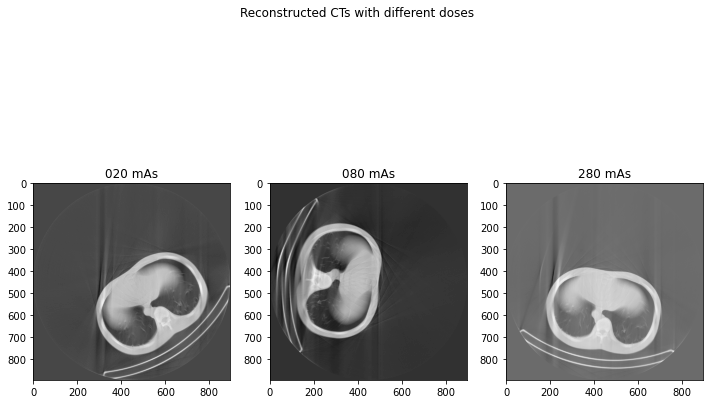

In [72]:
fig, axs = plt.subplots(1, len(sinograms), figsize=(15.0, 10.0))
fig.suptitle('Reconstructed CTs with different doses')
theta = np.linspace(0, 180, 1440, endpoint=False)

for idx, (dose, sinogram) in enumerate(sinograms.items()):
    reconstruction_fbp = iradon(np.array(sinogram),theta=theta,circle=True)
    axs[idx].set_title(f"{dose} mAs")#, size="small")
    axs[idx].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

## Further experiment

### Adding shift

In [ ]:
for i in np.asarray(np.linspace(0,2880,10)).astype(int):
    sinogram = create_sinogram_stupid_360(strips,shift=i)
    theta = np.linspace(0, 360, 2880, endpoint=False)
    reconstruction_fbp = iradon(np.array(sinogram),theta=theta, output_size=512)#, circle=True)
    
    plt.figure()
    plt.title("Reconstruction\nFiltered back projection")
    plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
    plt.show()

In [ ]:
for s in np.linspace(0,MAX_DISPLACEMENT,HALF_PROJECTIONS):
    for theta in np.linspace(0,HALF_VIEW_ANGLE,HALF_ANGLES):
        alpha=theta-math.asin(s/SMALL_R)
        print(alpha)